In [ ]:
#demand
import pandas as pd
import os
import glob
from pathlib import Path

csvs = []
parent_dir = 'demand'
for csv_file in glob.glob(os.path.join(parent_dir, '*.csv')):   #creates array with csv names
    csvs.append(csv_file)

files = []
li = []
for filename in sorted(csvs):
    files.append(Path(os.path.splitext(filename)[0]).stem)    #appends names of files for dates
    df = pd.read_csv(filename, index_col=None, header=0)    #creates dataframe for each file
    df.drop(df.tail(1).index,inplace=True)    
    li.append(df)   #appends each dataframe

df = pd.concat(li, axis=0, ignore_index=True)   #makes 1 big csv file with everyting combined
os.makedirs('Data', exist_ok=True)  
df.to_csv('Data/demand.csv')
df.head()

files = list(map(int, files))   
# print(*files[:5], sep='\n')
print(len(files))
print('size: ', df.size, sep='')

1096
size: 1262592


In [ ]:
df = pd.read_csv('Data/demand.csv')
df = df.drop(columns='Unnamed: 0')

f_files = []
for f in files:
  for i in range(288):    #appends filename for 288 entries 
    f_files.append(f)


print(len(f_files))
df['files'] = f_files   #makes column with filenames which are the dates

df.head(289)

315648


,Time,Day ahead forecast,Hour ahead forecast,Current demand,files
0,00:00,23437.0,22290.0,22216.0,20190101
1,00:05,22363.0,22089.0,22106.0,20190101
2,00:10,22363.0,22089.0,22130.0,20190101
3,00:15,22363.0,22089.0,22040.0,20190101
4,00:20,22363.0,21867.0,21963.0,20190101
...,...,...,...,...,...
284,23:40,22495.0,22133.0,22096.0,20190101
285,23:45,22495.0,22133.0,21961.0,20190101
286,23:50,22495.0,21813.0,21838.0,20190101
287,23:55,22495.0,21813.0,21716.0,20190101


In [ ]:
import datetime
df['Time'] = df['Time'] + ':00'
df['date'] = df['files'].astype(str) + df['Time']   #converts filenames into datetime and adds time

df['date'] = df['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d%H:%M:%S') if type(x)==str else np.NaN) 

In [ ]:
df = df.drop(columns=['Time', 'files'])   #drops filenames
df.head()

,Day ahead forecast,Hour ahead forecast,Current demand,date
0,23437.0,22290.0,22216.0,2019-01-01 00:00:00
1,22363.0,22089.0,22106.0,2019-01-01 00:05:00
2,22363.0,22089.0,22130.0,2019-01-01 00:10:00
3,22363.0,22089.0,22040.0,2019-01-01 00:15:00
4,22363.0,21867.0,21963.0,2019-01-01 00:20:00


In [ ]:
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)    #nan to mean value 
df.isna().sum()   #checks if there are any nan values

Day ahead forecast     0
Hour ahead forecast    0
Current demand         0
date                   0
dtype: int64

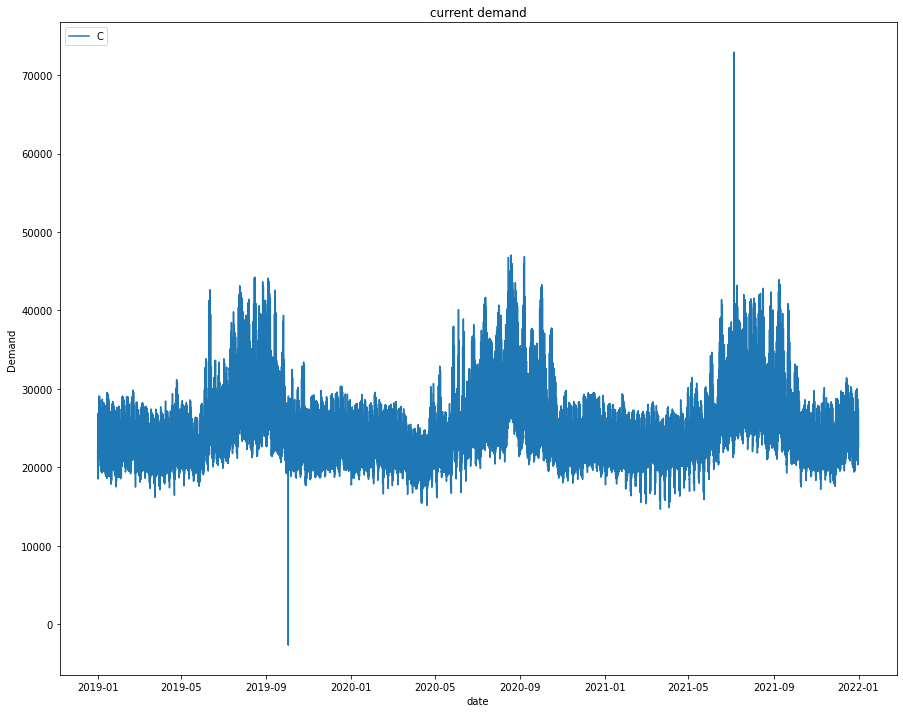

In [ ]:
from matplotlib import pyplot as plt
from datetime import datetime as dt
import matplotlib.dates as md
from pandas import Timedelta as td

%matplotlib inline

plt.figure(figsize=(15,12))   #plots current demand / time
plt.plot(df['date'], df['Current demand'])
plt.title('current demand')
plt.ylabel('Demand')
plt.xlabel('date')
plt.legend('Current Demand', loc='upper left')

plt.show()
print('\n')

# # plt.figure(figsize=(15,12))
# plt.plot(df['date'], df['Day ahead forecast'])
# plt.title('Day ahead forecast')
# plt.ylabel('Demand')
# plt.xlabel('date')
# plt.legend('Day ahead forecast', loc='upper left')

# plt.show()

In [ ]:
import missingno as msno

msno.bar(df)    #checks availability of data       

In [ ]:
import seaborn as sns

plt.figure(figsize=(15,12))   #finds correlation between data
sns.heatmap(df.corr(), annot=True, linewidths=1, fmt='.2g', cmap='coolwarm')
plt.xticks(rotation='horizontal')

In [ ]:
df['date_year'] = df['date'].dt.year
df['date_month'] = df['date'].dt.month
df['date_day'] = df['date'].dt.day            #makes each date information into a new collumn, year, month, etc   
df['date_hour'] = df['date'].dt.hour
df['date_min'] = df['date'].dt.minute
df['date_sec'] = df['date'].dt.second

df.head()

,Day ahead forecast,Hour ahead forecast,Current demand,date,date_year,date_month,date_day,date_hour,date_min,date_sec
0,23437.0,22290.0,22216.0,2019-01-01 00:00:00,2019,1,1,0,0,0
1,22363.0,22089.0,22106.0,2019-01-01 00:05:00,2019,1,1,0,5,0
2,22363.0,22089.0,22130.0,2019-01-01 00:10:00,2019,1,1,0,10,0
3,22363.0,22089.0,22040.0,2019-01-01 00:15:00,2019,1,1,0,15,0
4,22363.0,21867.0,21963.0,2019-01-01 00:20:00,2019,1,1,0,20,0


In [ ]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X = df['date'].values.reshape(-1,1)
y = df['Current demand']

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()     #scales data
scaler.fit(X)   
X = scaler.transform(X)


from sklearn.ensemble import IsolationForest    #finds outliers in dataset

iso = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.2), max_features=1.0)
iso.fit(df[['Current demand']])

df['outliers'] = iso.predict(df[['Current demand']])

indexer = []
indexer.append(df[df['outliers']==-1].index)    #saves indices of outliers

for i in indexer:
  print(df.loc[i,'date'])   #prints dates in which there are demand anomalies

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


136      2019-01-01 11:20:00
137      2019-01-01 11:25:00
138      2019-01-01 11:30:00
139      2019-01-01 11:35:00
140      2019-01-01 11:40:00
                 ...        
315014   2021-12-29 19:10:00
315015   2021-12-29 19:15:00
315016   2021-12-29 19:20:00
315017   2021-12-29 19:25:00
315018   2021-12-29 19:30:00
Name: date, Length: 62986, dtype: datetime64[ns]


In [ ]:
from sklearn.cluster import KMeans

k_rng = range(1,10)
sse = []

for k in k_rng:
  km = KMeans(n_clusters=k)
  km.fit(df['date'].values.reshape(-1,1), df['Current demand'])
  sse.append(km.inertia_)

sse

[2.358687411079672e+38,
 5.896912457628367e+37,
 2.6213926613346403e+37,
 1.4743628968232767e+37,
 9.43942796216635e+36,
 6.556055673608633e+36,
 4.824485768315769e+36,
 3.6999098326820954e+36,
 2.925586007127945e+36]

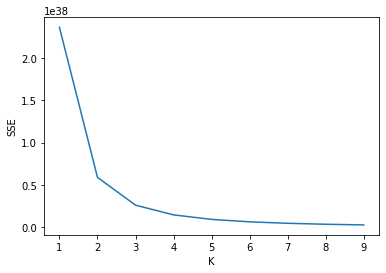

In [ ]:
plt.xlabel('K')     #elbow method for number of kmeans clusters
plt.ylabel('SSE')
plt.plot(k_rng, sse)

In [ ]:
df_resampled = df.set_index('date')   #resamples the data per year, week, anything we want to see 
# print(df_resampled.columns)

df_yearly = df_resampled['Current demand'].resample('AS').mean()   #yearly
df_yearly.columns = ['date', 'demand']
df_monthly = df_resampled['Current demand'].resample('M').mean()    #monthly
df_monthly.columns = ['date', 'demand']
df_weekly = df_resampled['Current demand'].resample('W').mean()   #weekly
df_weekly.columns = ['date', 'demand']

df_daily = df_resampled['Current demand'].resample('D').mean()   #daily
df_daily.columns = ['date', 'demand']

# y_df_daily = df_resampled['Day ahead forecast'].resample('D').mean()   #daily
# y_df_daily.columns = ['date', 'Day ahead forecast']

df_hourly = df_resampled['Current demand'].resample('H').mean()   #hourly
df_hourly.columns = ['date', 'demand']

# print(X_df_daily.columns, y_df_daily.columns)
df_daily

date
2019-01-01    21812.465278
2019-01-02    24134.614583
2019-01-03    24751.847222
2019-01-04    24432.812500
2019-01-05    23862.239583
                  ...     
2021-12-27    24566.732639
2021-12-28    25070.687500
2021-12-29    25498.704861
2021-12-30    24393.045139
2021-12-31    22803.527778
Freq: D, Name: Current demand, Length: 1096, dtype: float64

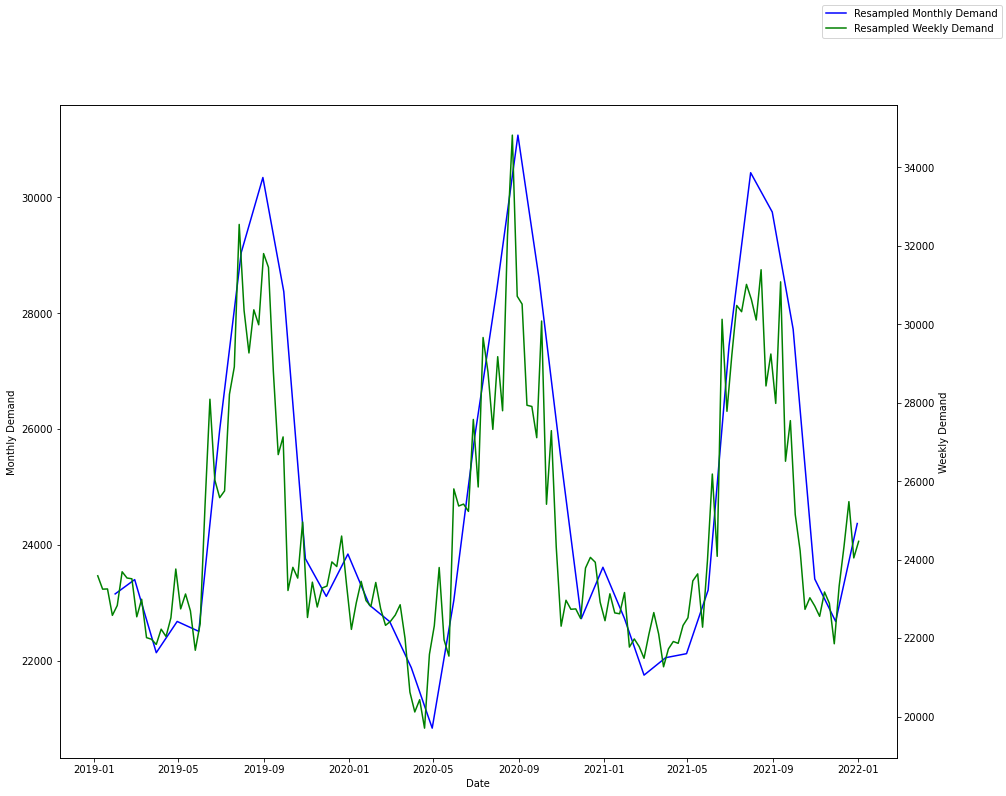

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))   #resample figs

ax.plot(df_monthly.index, df_monthly, color='blue')
ax.set_ylabel('Monthly Demand')
ax.set_xlabel('Date')

ax2 = ax.twinx()
ax2.plot(df_weekly.index, df_weekly, color='green')
ax2.set_ylabel('Weekly Demand')


# ax3 = ax.twinx()
# ax3.plot(df_daily.index, df_daily, color='red')

# ax4 = ax.twinx()
# ax4.plot(df_hourly.index, df_hourly, color='purple')

fig.legend(['Resampled Monthly Demand', 'Resampled Weekly Demand'], loc='upper right')
fig.show()

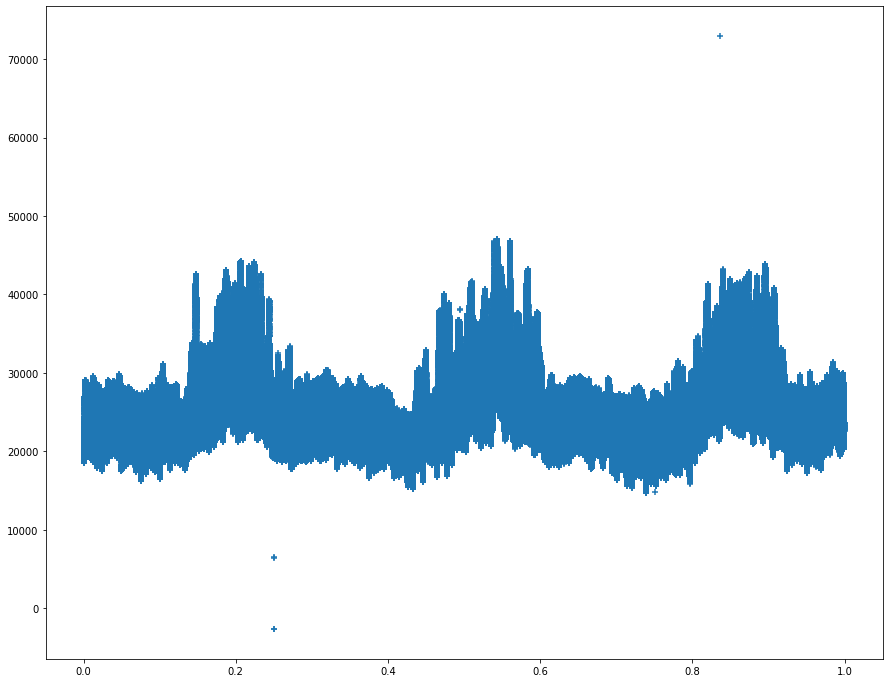

In [ ]:
plt.figure(figsize=(15,12))
plt.scatter(X,y, marker='+')

In [1]:
#sources
import pandas as pd
import os
import glob
from pathlib import Path

csvs_2 = []
parent_dir_2 = 'sources'
for csv_file in glob.glob(os.path.join(parent_dir_2, '*.csv')):   #appends filenames
    csvs_2.append(csv_file)

files_2 = []
li_2 = []
for filename in sorted(csvs_2):
    files_2.append(Path(os.path.splitext(filename)[0]).stem)    #creates dataframes of every file
    s_df = pd.read_csv(filename, index_col=None, header=0)
    # if len(s_df)!=288:
      # print(len(s_df))
    if len(s_df)>288:  
      s_df.drop(s_df.tail(1).index,inplace=True)
      # print(len(s_df))
      # print(s_df.Time)
    elif len(s_df)<288:
      # print(len(s_df))
      if len(s_df)==287:
        s_df2 = pd.DataFrame({'Time':['23:55']})
        s_df = pd.concat([s_df, s_df2], ignore_index=True, axis=0)    #missing data handling - in some csv there are missing hours so mean values are added
        s_df = s_df.fillna(s_df.mean())
        # print(s_df)
      elif len(s_df)==286:
        s_df3 = pd.DataFrame({'Time':['23:50']})
        s_df = pd.concat([s_df, s_df3], ignore_index=True, axis=0)
        s_df3 = pd.DataFrame({'Time':['23:55']})
        s_df = pd.concat([s_df, s_df3], ignore_index=True, axis=0)
        s_df = s_df.fillna(s_df.mean())
        # print(s_df)
      elif len(s_df)==285:
        s_df4 = pd.DataFrame({'Time':['23:45']})
        s_df = pd.concat([s_df, s_df4], ignore_index=True, axis=0)
        s_df4 = pd.DataFrame({'Time':['23:50']})
        s_df = pd.concat([s_df, s_df4], ignore_index=True, axis=0)
        s_df4 = pd.DataFrame({'Time':['23:55']})
        s_df = pd.concat([s_df, s_df4], ignore_index=True, axis=0)
        s_df = s_df.fillna(s_df.mean())
        # print(s_df)
      elif len(s_df)==277:
        s_df5 = pd.DataFrame({'Time':['23:05']})
        s_df = pd.concat([s_df, s_df5], ignore_index=True, axis=0)
        # minutes = 10
        # print(minutes)
        for minutes in range(10,60,5):
          s_df5 = pd.DataFrame({'Time':['23:'+str(minutes)]})
          s_df = pd.concat([s_df, s_df5], ignore_index=True, axis=0)
          # minutes+=5
        s_df = s_df.fillna(s_df.mean())
        # print(s_df)
    li_2.append(s_df)

s_df = pd.concat(li_2, axis=0, ignore_index=True)
os.makedirs('Sources_Data', exist_ok=True)        #creates 1 big csv file with everything
s_df.to_csv('Sources_Data/sources.csv')  

print('files: ', len(files_2), sep='')
print('length of df: ', len(s_df), sep='')
# s_df.head(288)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is 

files: 1096
length of df: 315648


In [2]:
s_df = pd.read_csv('Sources_Data/sources.csv')
s_df = s_df.drop(columns='Unnamed: 0')

f_files_2 = []
for f in files_2:
  for i in range(288):
    f_files_2.append(f)   #appends filenames to add to dataframe


print(len(f_files_2))
s_df['files'] = f_files_2   #adds filenames to dataframe

s_df.head()

315648


,Time,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural gas,Large hydro,Batteries,Imports,Other,Natural Gas,Large Hydro,files
0,00:00,0.0,2810.0,993.0,380.0,225.0,200.0,11.0,2273.0,7326.0,1924.0,6.0,6254.0,0.0,NaN,NaN,20190101
1,00:05,0.0,2862.0,993.0,381.0,226.0,201.0,11.0,2273.0,7200.0,1866.0,65.0,6266.0,0.0,NaN,NaN,20190101
2,00:10,0.0,2916.0,993.0,380.0,226.0,202.0,11.0,2272.0,7057.0,1849.0,64.0,6319.0,0.0,NaN,NaN,20190101
3,00:15,0.0,2920.0,993.0,378.0,223.0,203.0,11.0,2272.0,7007.0,1827.0,25.0,6354.0,0.0,NaN,NaN,20190101
4,00:20,0.0,2902.0,993.0,379.0,223.0,203.0,11.0,2273.0,6970.0,1840.0,32.0,6360.0,0.0,NaN,NaN,20190101


In [3]:
import datetime
s_df['Time'] = s_df['Time'] + ':00'
s_df['date'] = s_df['files'].astype(str) + s_df['Time']   #converts filenames to datetime

s_df['date'] = s_df['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y%m%d%H:%M:%S') if type(x)==str else np.NaN) 

In [4]:
s_df = s_df.drop(columns=['Time', 'files'])   #deletes filenames
# s_df = s_df.drop(columns=['files'])
s_df.head()

,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural gas,Large hydro,Batteries,Imports,Other,Natural Gas,Large Hydro,date
0,0.0,2810.0,993.0,380.0,225.0,200.0,11.0,2273.0,7326.0,1924.0,6.0,6254.0,0.0,NaN,NaN,2019-01-01 00:00:00
1,0.0,2862.0,993.0,381.0,226.0,201.0,11.0,2273.0,7200.0,1866.0,65.0,6266.0,0.0,NaN,NaN,2019-01-01 00:05:00
2,0.0,2916.0,993.0,380.0,226.0,202.0,11.0,2272.0,7057.0,1849.0,64.0,6319.0,0.0,NaN,NaN,2019-01-01 00:10:00
3,0.0,2920.0,993.0,378.0,223.0,203.0,11.0,2272.0,7007.0,1827.0,25.0,6354.0,0.0,NaN,NaN,2019-01-01 00:15:00
4,0.0,2902.0,993.0,379.0,223.0,203.0,11.0,2273.0,6970.0,1840.0,32.0,6360.0,0.0,NaN,NaN,2019-01-01 00:20:00


In [5]:
s_df = s_df.apply(lambda x: x.fillna(x.mean()),axis=0)    #nan values to mean
s_df.isna().sum()   #checks for nan values in every column

Solar          0
Wind           0
Geothermal     0
Biomass        0
Biogas         0
Small hydro    0
Coal           0
Nuclear        0
Natural gas    0
Large hydro    0
Batteries      0
Imports        0
Other          0
Natural Gas    0
Large Hydro    0
date           0
dtype: int64

In [6]:
s_df['date_year'] = s_df['date'].dt.year
s_df['date_month'] = s_df['date'].dt.month    #makes each date information into a new collumn, year, month, etc
s_df['date_day'] = s_df['date'].dt.day            
s_df['date_hour'] = s_df['date'].dt.hour
s_df['date_min'] = s_df['date'].dt.minute
s_df['date_sec'] = s_df['date'].dt.second

s_df.head()

,Solar,Wind,Geothermal,Biomass,Biogas,Small hydro,Coal,Nuclear,Natural gas,Large hydro,...,Other,Natural Gas,Large Hydro,date,date_year,date_month,date_day,date_hour,date_min,date_sec
0,0.0,2810.0,993.0,380.0,225.0,200.0,11.0,2273.0,7326.0,1924.0,...,0.0,9587.481279,1201.829254,2019-01-01 00:00:00,2019,1,1,0,0,0
1,0.0,2862.0,993.0,381.0,226.0,201.0,11.0,2273.0,7200.0,1866.0,...,0.0,9587.481279,1201.829254,2019-01-01 00:05:00,2019,1,1,0,5,0
2,0.0,2916.0,993.0,380.0,226.0,202.0,11.0,2272.0,7057.0,1849.0,...,0.0,9587.481279,1201.829254,2019-01-01 00:10:00,2019,1,1,0,10,0
3,0.0,2920.0,993.0,378.0,223.0,203.0,11.0,2272.0,7007.0,1827.0,...,0.0,9587.481279,1201.829254,2019-01-01 00:15:00,2019,1,1,0,15,0
4,0.0,2902.0,993.0,379.0,223.0,203.0,11.0,2273.0,6970.0,1840.0,...,0.0,9587.481279,1201.829254,2019-01-01 00:20:00,2019,1,1,0,20,0


In [7]:
s_df_resampled = s_df.set_index('date')   #resamples the data per year, week, anything we want to see
print(s_df_resampled.columns)


coal_df_minute = s_df_resampled['Coal'].resample('M').mean()    #resample in 5 minute frequency
# print(coal_df_minute.size)

natural_gas_df_minute = s_df_resampled['Natural gas'].resample('5T').mean()   
natural_gas_df_minute = natural_gas_df_minute.interpolate(method='pad')
# natural_gas_df_minute = natural_gas_df_minute.reset_index()
natural_gas_df_minute.columns = ['date', 'natural gas']

coal_df_minute = s_df_resampled['Coal'].resample('5T').mean()   
coal_df_minute = coal_df_minute.interpolate(method='pad')
# coal_df_minute = coal_df_minute.reset_index()
coal_df_minute.columns = ['date', 'coal']

batteries_df_minute = s_df_resampled['Batteries'].resample('5T').mean()   
batteries_df_minute = batteries_df_minute.interpolate(method='pad')
# batteries_df_minute = batteries_df_minute.reset_index()
batteries_df_minute.columns = ['date', 'batteries']

natural_gas_df_minute.head

Index(['Solar', 'Wind', 'Geothermal', 'Biomass', 'Biogas', 'Small hydro',
       'Coal', 'Nuclear', 'Natural gas', 'Large hydro', 'Batteries', 'Imports',
       'Other', 'Natural Gas', 'Large Hydro', 'date_year', 'date_month',
       'date_day', 'date_hour', 'date_min', 'date_sec'],
      dtype='object')


<bound method NDFrame.head of date
2019-01-01 00:00:00    7326.000000
2019-01-01 00:05:00    7200.000000
2019-01-01 00:10:00    7057.000000
2019-01-01 00:15:00    7007.000000
2019-01-01 00:20:00    6970.000000
                          ...     
2021-12-31 23:35:00    8101.128168
2021-12-31 23:40:00    8101.128168
2021-12-31 23:45:00    8101.128168
2021-12-31 23:50:00    8101.128168
2021-12-31 23:55:00    8101.128168
Freq: 5T, Name: Natural gas, Length: 315648, dtype: float64>

In [8]:
# natural_gas_df_minute = natural_gas_df_minute.drop(['coal', 'batteries'], axis=1)

train_size = int(len(natural_gas_df_minute) * 0.7)    #creates test and train datasets

test_size = len(natural_gas_df_minute) - train_size

train, test = natural_gas_df_minute.iloc[0:train_size], natural_gas_df_minute.iloc[train_size:len(natural_gas_df_minute)]

print(len(train), len(test))
# natural_gas_df_minute.columns
# train

220953 94695


In [9]:
import numpy as np

train = np.array(train)
train

array([7326., 7200., 7057., ..., 6710., 6695., 6792.])

In [10]:
 X_train, y_train = [], []

 for i in range(10, len(train)-5):    #creates sequences of values every 5 seconds
   X_train.append(train[i-5:i])
   y_train.append(train[i:i+5])

In [11]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [12]:
len(X_train), len(y_train)
X_train

array([[6926., 6919., 6885., 6789., 6761.],
       [6919., 6885., 6789., 6761., 6693.],
       [6885., 6789., 6761., 6693., 6728.],
       ...,
       [6468., 6493., 6504., 6497., 6509.],
       [6493., 6504., 6497., 6509., 6647.],
       [6504., 6497., 6509., 6647., 6715.]])

In [13]:
from sklearn.preprocessing import MinMaxScaler

x_scaler = MinMaxScaler()
X_train = x_scaler.fit_transform(X_train)   #scales data

y_scaler = MinMaxScaler()
y_train = y_scaler.fit_transform(y_train)

In [14]:
X_train.shape
# X_train = X_train.reshape(1420397, 5 ,1)
X_train = X_train.reshape(X_train.shape[0], 5 ,1)

X_train.shape

(220938, 5, 1)

In [15]:
# X_train = pd.DataFrame(X_train)
# y_train = pd.DataFrame(y_train)

In [16]:
test = np.array(test)

In [17]:
X_test, y_test = [], []

for i in range(10, len(test)-5):
  X_test.append(test[i-5:i])
  y_test.append(test[i:i+5])


In [18]:
X_test, y_test = np.array(X_test), np.array(y_test)

In [19]:
x_scaler = MinMaxScaler()
X_test = x_scaler.fit_transform(X_test)

y_scaler = MinMaxScaler()
y_test = y_scaler.fit_transform(y_test)

In [20]:
X_test.shape
X_test = X_test.reshape(X_test.shape[0], 5 ,1)
X_test.shape

(94680, 5, 1)

In [21]:
# X_test = pd.DataFrame(X_test)
# y_test = pd.DataFrame(y_test)

In [22]:
X_test

array([[[0.22381189],
        [0.2253048 ],
        [0.22758563],
        [0.22903707],
        [0.22928589]],

       [[0.2253048 ],
        [0.22758563],
        [0.22903707],
        [0.22928589],
        [0.23086174]],

       [[0.22758563],
        [0.22903707],
        [0.22928589],
        [0.23086174],
        [0.23048851]],

       ...,

       [[0.2717147 ],
        [0.2717147 ],
        [0.2717147 ],
        [0.2717147 ],
        [0.2717147 ]],

       [[0.2717147 ],
        [0.2717147 ],
        [0.2717147 ],
        [0.2717147 ],
        [0.2717147 ]],

       [[0.2717147 ],
        [0.2717147 ],
        [0.2717147 ],
        [0.2717147 ],
        [0.2717147 ]]])

In [23]:
X_train = X_train[:10000]
y_train = y_train[:10000]

X_test = X_test[:10000]
y_test = y_test[:10000]

Epoch 1/50
311/313 [============================>.] - ETA: 0s - loss: 0.0718 - accuracy: 0.1973
Epoch 1: accuracy improved from -inf to 0.19670, saving model to best_m.h5
313/313 [==============================] - 9s 22ms/step - loss: 0.0715 - accuracy: 0.1967 - val_loss: 0.1352 - val_accuracy: 0.3488
Epoch 2/50
311/313 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.2143
Epoch 2: accuracy improved from 0.19670 to 0.21360, saving model to best_m.h5
313/313 [==============================] - 5s 16ms/step - loss: 0.0058 - accuracy: 0.2136 - val_loss: 0.1328 - val_accuracy: 0.3653
Epoch 3/50
310/313 [============================>.] - ETA: 0s - loss: 0.0060 - accuracy: 0.1944
Epoch 3: accuracy did not improve from 0.21360
313/313 [==============================] - 5s 16ms/step - loss: 0.0060 - accuracy: 0.1939 - val_loss: 0.1377 - val_accuracy: 0.2290
Epoch 4/50
311/313 [============================>.] - ETA: 0s - loss: 0.0058 - accuracy: 0.2239
Epoch 4: accuracy im

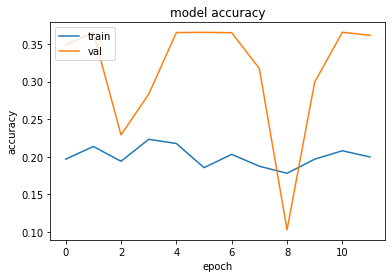

Epoch 1/50
309/313 [============================>.] - ETA: 0s - loss: 0.0444 - accuracy: 0.1911
Epoch 1: accuracy improved from -inf to 0.19210, saving model to best_m.h5
313/313 [==============================] - 6s 16ms/step - loss: 0.0439 - accuracy: 0.1921 - val_loss: 0.2785 - val_accuracy: 0.3653
Epoch 2/50
310/313 [============================>.] - ETA: 0s - loss: 0.0047 - accuracy: 0.2183
Epoch 2: accuracy improved from 0.19210 to 0.21800, saving model to best_m.h5
313/313 [==============================] - 5s 16ms/step - loss: 0.0048 - accuracy: 0.2180 - val_loss: 0.2769 - val_accuracy: 0.3653
Epoch 3/50
313/313 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.2187
Epoch 3: accuracy improved from 0.21800 to 0.21870, saving model to best_m.h5
313/313 [==============================] - 5s 16ms/step - loss: 0.0036 - accuracy: 0.2187 - val_loss: 0.2688 - val_accuracy: 0.3653
Epoch 4/50
312/313 [============================>.] - ETA: 0s - loss: 0.0032 - accura

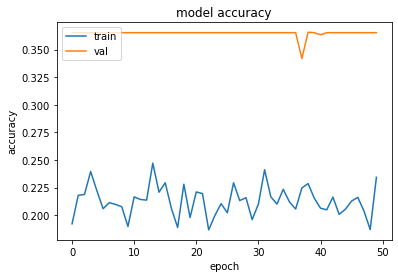

Epoch 1/50
312/313 [============================>.] - ETA: 0s - loss: 0.0296 - accuracy: 0.1956
Epoch 1: accuracy improved from -inf to 0.19530, saving model to best_m.h5
313/313 [==============================] - 6s 15ms/step - loss: 0.0295 - accuracy: 0.1953 - val_loss: 0.2224 - val_accuracy: 0.1025
Epoch 2/50
310/313 [============================>.] - ETA: 0s - loss: 0.0062 - accuracy: 0.2078
Epoch 2: accuracy improved from 0.19530 to 0.20770, saving model to best_m.h5
313/313 [==============================] - 5s 16ms/step - loss: 0.0062 - accuracy: 0.2077 - val_loss: 0.2241 - val_accuracy: 0.0952
Epoch 3/50
310/313 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.2038
Epoch 3: accuracy did not improve from 0.20770
313/313 [==============================] - 5s 16ms/step - loss: 0.0041 - accuracy: 0.2028 - val_loss: 0.2302 - val_accuracy: 0.0959
Epoch 4/50
313/313 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.1918
Epoch 4: accuracy di

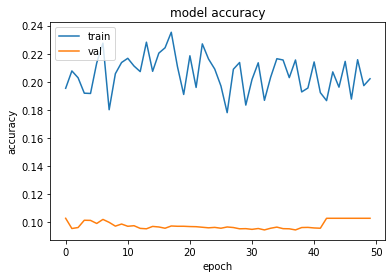

Epoch 1/50
313/313 [==============================] - ETA: 0s - loss: 0.0348 - accuracy: 0.1732
Epoch 1: accuracy improved from -inf to 0.17320, saving model to best_m.h5
313/313 [==============================] - 6s 15ms/step - loss: 0.0348 - accuracy: 0.1732 - val_loss: 0.2106 - val_accuracy: 0.3172
Epoch 2/50
309/313 [============================>.] - ETA: 0s - loss: 0.0068 - accuracy: 0.2099
Epoch 2: accuracy improved from 0.17320 to 0.20840, saving model to best_m.h5
313/313 [==============================] - 5s 16ms/step - loss: 0.0068 - accuracy: 0.2084 - val_loss: 0.2466 - val_accuracy: 0.3139
Epoch 3/50
312/313 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.2218
Epoch 3: accuracy improved from 0.20840 to 0.22160, saving model to best_m.h5
313/313 [==============================] - 5s 16ms/step - loss: 0.0042 - accuracy: 0.2216 - val_loss: 0.2460 - val_accuracy: 0.3629
Epoch 4/50
310/313 [============================>.] - ETA: 0s - loss: 0.0033 - accura

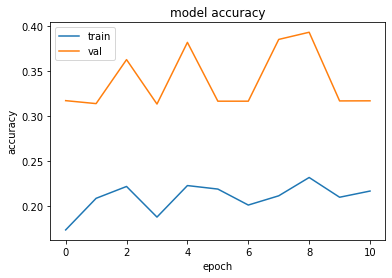

Epoch 1/50
312/313 [============================>.] - ETA: 0s - loss: 0.0340 - accuracy: 0.1954
Epoch 1: accuracy improved from -inf to 0.19570, saving model to best_m.h5
313/313 [==============================] - 6s 17ms/step - loss: 0.0340 - accuracy: 0.1957 - val_loss: 0.2154 - val_accuracy: 0.3653
Epoch 2/50
311/313 [============================>.] - ETA: 0s - loss: 0.0055 - accuracy: 0.1486
Epoch 2: accuracy did not improve from 0.19570
313/313 [==============================] - 5s 16ms/step - loss: 0.0055 - accuracy: 0.1482 - val_loss: 0.2225 - val_accuracy: 0.3653
Epoch 3/50
311/313 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.1895
Epoch 3: accuracy did not improve from 0.19570
313/313 [==============================] - 5s 16ms/step - loss: 0.0045 - accuracy: 0.1904 - val_loss: 0.2261 - val_accuracy: 0.3642
Epoch 4/50
312/313 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.1957
Epoch 4: accuracy improved from 0.19570 to 0.19580,

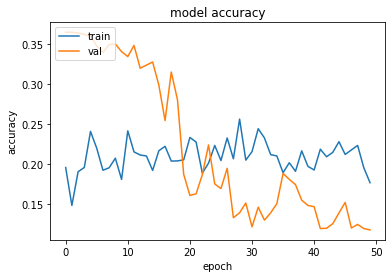

In [28]:
from tensorflow import keras
from keras.optimizers import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector
from tensorflow.keras.layers import Dense, Dropout, TimeDistributed
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold


kfold = KFold(n_splits=5, shuffle=True)
rmseList = []

# opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.2)
opt = keras.optimizers.Adam()


for i, (train, test) in enumerate(kfold.split(X_train)):
  model = Sequential()

  model.add(LSTM(units=200, activation='relu', input_shape=(5,1)))
  model.add(Dense(5))

  # model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
  # model.add(Dropout(rate=0.2))
  # model.add(RepeatVector(n=X_train.shape[1]))
  # model.add(LSTM(units=64, return_sequences=True))
  # model.add(Dropout(rate=0.2))
  # model.add(TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))


  model.compile(
  optimizer=opt,
  # loss='binary_crossentropy',
  # loss='mean_squared_error',
  loss='mae',
  # metrics=[rmse]
  # metrics=['binary_accuracy']
  metrics=['accuracy']
  )

  es = EarlyStopping(             #Early stopping
      monitor='val_loss',
      patience=10,
      verbose=0,
      mode='min'
  )

  mc = ModelCheckpoint(       #Model checkpoint to save best model each epoch
      'best_m.h5',
      monitor='accuracy',
      mode='max',
      verbose=1,
      save_best_only=True
  )

  history = model.fit(X_train, y_train,           #Model fit
            validation_data=(X_test, y_test),
            epochs=50,
            callbacks=[es, mc],
            verbose=1)

  print('val_loss, val_acc: ', model.evaluate(X_test, y_test), sep='')        #Model evaluation

  scores = model.evaluate(X_test, y_test, verbose=0)
  rmseList.append(scores[0])
  print("Fold :", i+1, " loss", scores[0])

  plt.plot(history.history['accuracy'])            #Plots accuracy, val_accuracy/epoch graph
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

